In [42]:
# %load_ext nb_black
# %load_ext lab_black

This is my project for computational intelligence based on kaggle dataset of monkeys.

In [43]:
# Import packages


import os
from pathlib import Path

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.utils import np_utils
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.layers import (
    Conv2D,
    Activation,
    MaxPooling2D,
    Dropout,
    Flatten,
    Dense,
)
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline

Set data folders

In [44]:
data_folder = "data"
training_directory = os.path.join(data_folder, "training", "training")
test_directory = os.path.join(data_folder, "validation", "validation")
labels_file = os.path.join(data_folder, "monkey_labels.txt")

Read labels

In [45]:
labels_df = pd.read_csv(labels_file)
labels_df = labels_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
labels_df.columns = labels_df.columns.str.strip()
labels = labels_df["Common Name"]

Read images from files

In [46]:
def convert_image_to_vector(input_image, size=(150, 150)):
    resized_image = cv2.resize(input_image, size)
    return resized_image


def convert_image_to_vector_rgb(input_image, size=(150, 150)):
    resized_image = cv2.resize(input_image, size)
    img_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    return img_rgb


def convert_image_to_vector_cubic(input_image, size=(150, 150)):
    resized_image = cv2.resize(input_image, size, interpolation=cv2.INTER_CUBIC)
    return resized_image


def convert_image_to_vector_both(input_image, size=(150, 150)):
    resized_image = cv2.resize(input_image, size, interpolation=cv2.INTER_CUBIC)
    img_rgb_cubic = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    return img_rgb_cubic


def normalize(input_image):
    mean, std = input_image.mean(), input_image.std()
    input_image = (input_image - mean) / std
    return input_image


def process_image(file):
    image_file = cv2.imread(file)
    image_pixels = convert_image_to_vector_both(image_file, size=(150, 150))
    image_pixels = normalize(image_pixels)
    image_label = file.split(os.path.sep)[-2][1]
    return image_pixels, image_label

In [47]:
training_images = []
training_images_flattened = []
training_labels = []

for path in Path(training_directory).rglob("*.jpg"):
    image, label = process_image(str(path))
    training_images.append(image)
    training_images_flattened.append(image.flatten())
    training_labels.append(label)

test_images = []
test_images_flattened = []
test_labels = []

for path in Path(test_directory).rglob("*.jpg"):
    image, label = process_image(str(path))
    test_images.append(image)
    test_labels.append(label)
    test_images_flattened.append(image.flatten())

0               mantled_howler
1                 patas_monkey
2                  bald_uakari
3             japanese_macaque
4               pygmy_marmoset
5        white_headed_capuchin
6             silvery_marmoset
7       common_squirrel_monkey
8    black_headed_night_monkey
9               nilgiri_langur
Name: Common Name, dtype: object


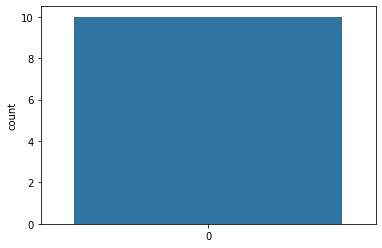

In [48]:
df = pd.DataFrame()
df["labels"] = training_labels
lab = df["labels"]
counts = lab.value_counts()
sns.countplot(data=counts)
print(labels)

In [49]:
test_images = np.array(test_images)
test_labels = np.array(test_labels)
test_images_flattened = np.array(test_images_flattened)
training_labels_for_flattened = training_labels

training_images = np.array(training_images)
training_labels = np.array(training_labels)
training_images_flattened = np.array(training_images_flattened)
test_labels_for_flattened = test_labels

num_classes = len(np.unique(training_labels))
label_encoder = LabelEncoder()
training_labels = label_encoder.fit_transform(training_labels)
test_labels = label_encoder.fit_transform(test_labels)
test_labels = np_utils.to_categorical(test_labels, num_classes)
training_labels = np_utils.to_categorical(training_labels, num_classes)

In [50]:
# LINEAR REGRESSION
print(training_images_flattened)
# print(training_labels_for_flattened)
# print(test_images_flattened)
# print(test_labels_for_flattened)
normalzed = normalize(training_images_flattened)
print(normalzed)
# data = pd.DataFrame(training_images_flattened).replace(np.inf, np.nan).replace(-np.inf, np.nan).dropna()
# test_data = pd.DataFrame(test_images_flattened).replace(np.inf, np.nan).replace(-np.inf, np.nan).dropna()
lin_reg = LinearRegression()
lin_reg.fit(normalize(training_images_flattened), training_labels_for_flattened)
predictions = lin_reg.predict(test_images_flattened)

plt.scatter(training_images_flattened, training_labels_for_flattened, color="black")
plt.plot(test_images_flattened, test_labels_for_flattened, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

[[ 0.15326032  0.08908637 -0.57832269 ...  0.46129527  0.14042553
  -0.50131395]
 [-0.57261757 -0.28969608 -1.17174544 ...  0.9252021   0.69220793
   0.50914108]
 [-1.24023896 -0.43579569 -0.59668434 ... -0.65518931 -0.5820581
  -0.97696662]
 ...
 [ 1.41790021  1.43556472  1.22359059 ...  0.18138443  0.57000368
  -0.93147977]
 [ 1.08150812  0.68379774 -0.01804409 ... -0.2753861   0.26269264
  -0.97722794]
 [ 1.6093684   1.6382488   1.5660478  ...  1.19060261  1.06064081
   1.01732021]]
[[ 0.15326032  0.08908637 -0.57832269 ...  0.46129527  0.14042553
  -0.50131395]
 [-0.57261757 -0.28969608 -1.17174544 ...  0.9252021   0.69220793
   0.50914108]
 [-1.24023896 -0.43579569 -0.59668434 ... -0.65518931 -0.5820581
  -0.97696662]
 ...
 [ 1.41790021  1.43556472  1.22359059 ...  0.18138443  0.57000368
  -0.93147977]
 [ 1.08150812  0.68379774 -0.01804409 ... -0.2753861   0.26269264
  -0.97722794]
 [ 1.6093684   1.6382488   1.5660478  ...  1.19060261  1.06064081
   1.01732021]]


LinAlgError: SVD did not converge in Linear Least Squares

In [ ]:
# TEST KNN classifier
model7 = KNeighborsClassifier(n_neighbors=7)
model14 = KNeighborsClassifier(n_neighbors=14)
model2 = KNeighborsClassifier(n_neighbors=2)
model1 = KNeighborsClassifier(n_neighbors=1)

model1.fit(training_images_flattened, training_labels)
model2.fit(training_images_flattened, training_labels)
model7.fit(training_images_flattened, training_labels)
model14.fit(training_images_flattened, training_labels)

acc1 = model1.score(test_images_flattened, test_labels)
acc2 = model2.score(test_images_flattened, test_labels)
acc7 = model7.score(test_images_flattened, test_labels)
acc14 = model14.score(test_images_flattened, test_labels)

print("Accuracy for 1n: {:.2f}%".format(acc1 * 100))
print("Accuracy for 2n: {:.2f}%".format(acc2 * 100))
print("Accuracy for 7n: {:.2f}%".format(acc7 * 100))
print("Accuracy for 14n: {:.2f}%".format(acc14 * 100))


In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation("softmax"))

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


In [ ]:
es = EarlyStopping(
    monitor="loss",
    mode="min",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint_cb = ModelCheckpoint(
    "Best_model.h5",
    save_best_only=True,
    monitor = "loss",
    mode="min"
)

reduce_lr = ReduceLROnPlateau(
    monitor = "loss",
    factor = 0.3,
    patience = 3,
    min_lr = 1e-5,
    mode = "min",
    verbose = 1
)

model.fit(
    training_images,
    training_labels,
    epochs=30,
    callbacks=[checkpoint_cb, es, reduce_lr]
)
model.save("Model15015032firstsimple"+".h5")

Test accuracy

In [ ]:
test_loss, test_acc = model.evaluate(
    test_images,
    test_labels,
    verbose=2
)
print("\nTest accuracy:", test_acc)

Test on one image

In [ ]:
n = 200
test_image = test_images[n]
test_image = np.expand_dims(test_image, axis=0)
prediction = model.predict(test_image, batch_size=1)
print(labels[np.argmax(prediction)])
print(labels)

In [ ]:
IMG_SIZE = 150
size = (IMG_SIZE,IMG_SIZE)

datagenerator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = "nearest",
    validation_split=0.2
)

train_set = datagenerator.flow_from_directory(
    training_directory,
    target_size = size,
    batch_size=32,
    seed = 42,
    subset="training",
    shuffle = True,
    class_mode="categorical"
)

val_set = datagenerator.flow_from_directory(
    training_directory,
    target_size = size,
    batch_size=32,
    seed = 42,
    subset="validation",
    shuffle = True,
    class_mode="categorical"
)


test_set = datagenerator.flow_from_directory(
    test_directory,
    target_size = size,
    batch_size = 32,
    seed = 42,
    class_mode = "categorical",
    shuffle = False
)

from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB3

In [ ]:
image_generator_model = Sequential()
image_generator_model.add(EfficientNetB3(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False, weights = "imagenet"))
image_generator_model.add(GlobalAveragePooling2D())
image_generator_model.add(Flatten())
image_generator_model.add(Dense(512, activation = "relu", bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
image_generator_model.add(Dropout(0.7))
image_generator_model.add(Dense(10, activation = "softmax"))

image_generator_model.summary()

In [ ]:
keras.utils.plot_model(image_generator_model)

In [ ]:
EPOCHS = 30
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
STEP_SIZE_VALID = val_set.n//val_set.batch_size

image_generator_model.compile(
    optimizer = "adam",
    loss ="categorical_crossentropy",
    metrics = ["acc"]
)


image_generator_model.fit(
    train_set,
    validation_data = val_set,
    epochs= EPOCHS,
    batch_size = 32,
    steps_per_epoch = STEP_SIZE_TRAIN,
    validation_steps = STEP_SIZE_VALID,
    callbacks=[es, reduce_lr]
)
print(image_generator_model.evaluate(test_set))
image_generator_model.save("Model15015032second"+".h5")

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest")

train_generator = train_datagen.flow_from_directory(training_directory,
                                                    target_size=(150, 150),
                                                    batch_size= 64,
                                                    seed=1,
                                                    shuffle=True,
                                                    class_mode="categorical")

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = test_datagen.flow_from_directory(test_directory,
                                                  target_size=(150, 150),
                                                  batch_size=64,
                                                  seed=1,
                                                  shuffle=False,
                                                  class_mode="categorical")

train_num = train_generator.samples
validation_num = validation_generator.samples

In [ ]:
num_classes = 10

monkey_model = Sequential()
monkey_model.add(Conv2D(32,(3,3), input_shape=(150,150,3), activation="relu"))
monkey_model.add(MaxPooling2D(pool_size=(2,2)))
monkey_model.add(Conv2D(32,(3,3), activation="relu"))
monkey_model.add(MaxPooling2D(pool_size=(2,2)))
monkey_model.add(Conv2D(64,(3,3), padding="same", activation="relu"))
monkey_model.add(Conv2D(64,(3,3), activation="relu"))
monkey_model.add(MaxPooling2D(pool_size=(2,2)))
monkey_model.add(Dropout(0.25))
monkey_model.add(Flatten())
monkey_model.add(Dense(512))
monkey_model.add(Activation("relu"))
monkey_model.add(Dropout(0.5))
monkey_model.add(Dense(num_classes))
monkey_model.add(Activation("softmax"))

In [ ]:
monkey_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["acc"]
)
monkey_model.summary()

In [ ]:
callbacks_list = [es, reduce_lr]
batch_size = 64

monkey_model.fit(
    train_generator,
    steps_per_epoch = train_num // batch_size,
    epochs = 50,
    validation_data = train_generator,
    validation_steps = validation_num // batch_size,
    callbacks = callbacks_list,
    verbose = 1
)
monkey_model.save("Model15015032third"+".h5")

In [ ]:
monkey_model.evaluate(validation_generator)